# **Dataset 4**

### **Import Packages**

In [1]:
import multiprocessing
import subprocess
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from Data_Generation.data_synthesizer import ds_generate_data
from Data_Generation.synthetic_data_vault import sdv_generate_data
from Data_Evaluation.utility import run_utility_eval
from Data_Evaluation.resemblance import pairwise_correlation_diff, jsd, wd
from Data_Evaluation.privacy import dcr, nndr, mia


### **Exploratory Data Analysis**

In [2]:
# Load dataset as dataframe
data_path = "Original_Data/Dataset_4/Dataset_4.csv"
original_data = pd.read_csv(data_path)
original_data.head()


,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [3]:
# Get general information about the dataset
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


In [4]:
# Check for missing values
original_data.isnull().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

Found 173 missing values in column 'score'. Replace with mean value.

In [5]:
original_data.fillna(original_data.mean().round(0), inplace=True)
original_data.isnull().sum()

id_assessment     0
id_student        0
date_submitted    0
is_banked         0
score             0
dtype: int64

In [6]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173912 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


<Axes: xlabel='score', ylabel='Count'>

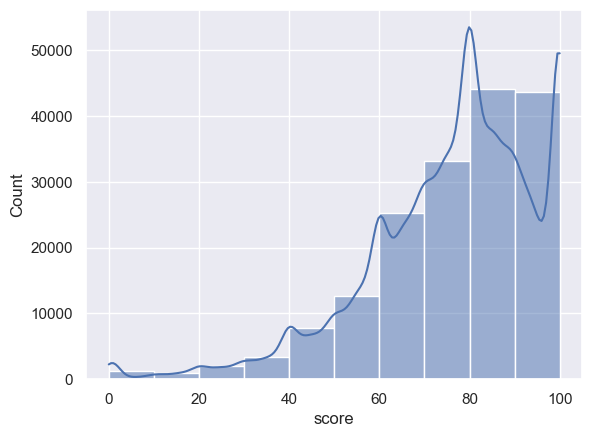

In [7]:
# Check score distribution
sns.histplot(original_data['score'], bins=10, kde=True)

In [8]:
# Check categorical columns
categorical_cols = original_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(col, original_data[col].unique())

### **Synthetic Data Generation**

In [9]:
# Set the start method of the multiprocessing module to 'fork' to avoid an error
multiprocessing.set_start_method('fork', force=True)

# Number of samples to generate
n = 5000

train_data, test_data = train_test_split(original_data, test_size=0.3, random_state=42)
train_data.to_csv("Original_Data/Dataset_4/train_data.csv", index=False)
test_data.to_csv("Original_Data/Dataset_4/test_data.csv", index=False)

In [10]:
# !! Only use if synthetic data has is not generated yet !!

# Use train_data.csv to fit SDG models and generate synthetic data
# data_path = "Original_Data/train_data.csv"
# arguments = [data_path, str(n), "4"]

# print("Sampling synthpop...")
# result = subprocess.run(['Rscript', 'Data_Generation/synthpop.R',   *arguments], capture_output=True, text=True)

# print("Sampling DataSynthesizer...")
# ds_generate_data(data_path=data_path, num_samples=n, dataset_nr="4")

# sdv_generate_data(data_path=data_path, num_samples=n, dataset_nr="4")

Encode all categorical columns of both original (train+test) data and synthetic data using label encoding

In [11]:

synthpop = pd.read_csv("Synthetic_Data/Dataset_4/synthpop_samples.csv")
ds = pd.read_csv("Synthetic_Data/Dataset_4/ds_samples.csv")
tvae = pd.read_csv("Synthetic_Data/Dataset_4/tvae_samples.csv")
gaussian_copula = pd.read_csv("Synthetic_Data/Dataset_4/gaussian_samples.csv")
copula_gan = pd.read_csv("Synthetic_Data/Dataset_4/copula_gan_samples.csv")
ctgan = pd.read_csv("Synthetic_Data/Dataset_4/ctgan_samples.csv")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])

    synthpop[col] = le.fit_transform(synthpop[col])
    ds[col] = le.fit_transform(ds[col])
    tvae[col] = le.fit_transform(tvae[col])
    gaussian_copula[col] = le.fit_transform(gaussian_copula[col])
    copula_gan[col] = le.fit_transform(copula_gan[col])
    ctgan[col] = le.fit_transform(ctgan[col])

    label_encoders[col] = le

### **Utility Evaluation**

Prepare utility evaluation

In [12]:
models = [synthpop, ds, tvae, gaussian_copula, copula_gan, ctgan]
model_names = ["synthpop", "ds", "tvae", "gaussian_copula", "copula_gan", "ctgan"]
target_col = "score"

for model in models:
    model[target_col] = pd.cut(model[target_col], bins=[-1, 50, 80, 100], labels=[0, 1, 2])

train_data[target_col] = pd.cut(train_data[target_col], bins=[-1, 50, 80, 100], labels=[0, 1, 2])
test_data[target_col] = pd.cut(test_data[target_col], bins=[-1, 50, 80, 100], labels=[0, 1, 2])

Run random forest classifier for utility evaluation

In [13]:
rf_results = {}
rf_df = pd.read_csv("Evaluation_Results/RF_Results.csv")
rows = []

for i, model in enumerate(models):
    rf_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "random_forest")

    acc_diff = rf_results[model_names[i]]["acc_diff"]
    f1_diff = rf_results[model_names[i]]["f1_diff"]
    roc_auc_diff = rf_results[model_names[i]]["roc_auc_diff"]

    rows.append([4, model_names[i], acc_diff, f1_diff, roc_auc_diff])

rows = pd.DataFrame(rows, columns=rf_df.columns)
rf_df = pd.concat([rf_df, rows])
rf_df.to_csv("Evaluation_Results/RF_Results.csv", index=False)
rf_df.head()

,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
0,1,synthpop,0.07,0.07,0.05
1,1,ds,0.46,0.47,0.49
2,1,tvae,0.19,0.24,0.10
3,1,gaussian_copula,0.37,0.42,0.40
4,1,copula_gan,0.42,0.44,0.40


Run logistic regression for utility evaluation

In [14]:
lr_results = {}
lr_df = pd.read_csv("Evaluation_Results/LR_Results.csv")
rows = []

for i, model in enumerate(models):
    lr_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "logistic_regression")

    acc_diff = lr_results[model_names[i]]["acc_diff"]
    f1_diff = lr_results[model_names[i]]["f1_diff"]
    roc_auc_diff = lr_results[model_names[i]]["roc_auc_diff"]

    rows.append([4, model_names[i], acc_diff, f1_diff, roc_auc_diff])

rows = pd.DataFrame(rows, columns=lr_df.columns)
lr_df = pd.concat([lr_df, rows])
lr_df.to_csv("Evaluation_Results/LR_Results.csv", index=False)
lr_df.tail(7)

,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
17,3,ctgan,-0.08,0.00,-0.17
0,4,synthpop,-0.02,-0.01,-0.02
1,4,ds,-0.01,0.02,0.00
2,4,tvae,0.00,0.08,0.00
3,4,gaussian_copula,0.04,0.19,0.00
4,4,copula_gan,0.00,0.15,0.01
5,4,ctgan,-0.02,-0.01,0.00


Run multilayer perceptron (MLP)

In [15]:
mlp_results = {}
mlp_df = pd.read_csv("Evaluation_Results/MLP_Results.csv")
rows = []

for i, model in enumerate(models):
    mlp_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "multilayer_perceptron")

    acc_diff = mlp_results[model_names[i]]["acc_diff"]
    f1_diff = mlp_results[model_names[i]]["f1_diff"]
    roc_auc_diff = mlp_results[model_names[i]]["roc_auc_diff"]

    rows.append([4, model_names[i], acc_diff, f1_diff, roc_auc_diff])

rows = pd.DataFrame(rows, columns=mlp_df.columns)
mlp_df = pd.concat([mlp_df, rows])
mlp_df.to_csv("Evaluation_Results/MLP_Results.csv", index=False)
mlp_df.tail(7)

,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
17,3,ctgan,0.00,0.00,-0.11
0,4,synthpop,0.00,0.03,0.01
1,4,ds,0.00,0.03,0.01
2,4,tvae,0.36,0.28,0.02
3,4,gaussian_copula,0.00,0.03,0.01
4,4,copula_gan,0.02,-0.06,0.00
5,4,ctgan,0.00,0.03,0.01


### **Resemblance**

Run multiple resemblance metrics: Difference in pairwise correlation, Jensen-Shannon divergence, Wasserstein distance

- Correlation distance diff : lower values are better
- JSD in [0,1] range: lower values are better
- WD: lower values are better


**Difference in pairwise correlation:**

In [16]:
corr_diff_df = pd.read_csv("Evaluation_Results/corr_diff.csv")
rows = []

for i, model in enumerate(models):
    result = pairwise_correlation_diff(train_data, model)
    rows.append([4,model_names[i], result])

rows = pd.DataFrame(rows, columns=corr_diff_df.columns)
corr_diff_df = pd.concat([corr_diff_df, rows])
corr_diff_df.to_csv("Evaluation_Results/corr_diff.csv", index=False)
corr_diff_df.tail(7)

,Dataset,Model,Pairwise Corr Diff
17,3,ctgan,0.239476
0,4,synthpop,0.007705
1,4,ds,0.049791
2,4,tvae,0.036249
3,4,gaussian_copula,0.027335
4,4,copula_gan,0.093194
5,4,ctgan,0.097790


**Jensen-Shannon Divergence**

In [17]:
jsd_df = pd.read_csv("Evaluation_Results/jsd.csv")
rows = []

for i, model in enumerate(models):
    result = jsd(train_data, model)
    rows.append([4,model_names[i], result])

rows = pd.DataFrame(rows, columns=jsd_df.columns)
jsd_df = pd.concat([jsd_df, rows])
jsd_df.to_csv("Evaluation_Results/jsd.csv", index=False)
jsd_df.tail(7)

,Dataset,Model,JSD Diff
17,3,ctgan,0.143693
0,4,synthpop,0.081237
1,4,ds,0.288065
2,4,tvae,0.163723
3,4,gaussian_copula,0.296455
4,4,copula_gan,0.245821
5,4,ctgan,0.230777


**Wasserstein Distance**

In [18]:
wd_df = pd.read_csv("Evaluation_Results/wd.csv")
rows = []

for i, model in enumerate(models):
    result = wd(train_data, model)
    rows.append([4,model_names[i], result])

rows = pd.DataFrame(rows, columns=wd_df.columns)
wd_df = pd.concat([wd_df, rows])
wd_df.to_csv("Evaluation_Results/wd.csv", index=False)
wd_df.tail(7)

,Dataset,Model,WD Diff
17,3,ctgan,0.029097
0,4,synthpop,0.000918
1,4,ds,0.006126
2,4,tvae,0.013464
3,4,gaussian_copula,0.014836
4,4,copula_gan,0.079415
5,4,ctgan,0.077721


### **Privacy**

Run privacy evaluation using Distance to closest Record (DCR), Nearest Neighbour Difference Ratio (NNDR) and Membership Inference Attack (MIA)

- **DCR**: a value of zero indicates that the synthetic record is an identical copy of the original
one -> leak of real information, higher values indicate more privacy

- **NNDR**: ratio is within [0,1], higher values indicate better privacy

- **MIA**: both accuracy and precision should be below 0.5 for all thresholds for strong privacy preservation

**Distance to closest record (DCR)**

In [19]:
dcr_df = pd.read_csv("Evaluation_Results/dcr.csv")
rows = []

for i, model in enumerate(models):
    result = dcr(train_data, model, model_names[i], dataset_nr=4, save_hist=True)
    result_within_real = dcr(train_data, model, model_names[i], dataset_nr=4, within="Original", save_hist=True)
    result_within_synth = dcr(train_data, model, model_names[i], dataset_nr=4, within="Synthetic", save_hist=True)
    rows.append([4,model_names[i], result, result_within_real, result_within_synth])

rows = pd.DataFrame(rows, columns=dcr_df.columns)
dcr_df = pd.concat([dcr_df, rows])
dcr_df.to_csv("Evaluation_Results/dcr.csv", index=False)
dcr_df.tail(7)

,Dataset,Model,Avg DCR
17,3,ctgan,0.259526
0,4,synthpop,0.185198
1,4,ds,0.191679
2,4,tvae,0.177401
3,4,gaussian_copula,0.192767
4,4,copula_gan,0.265511
5,4,ctgan,0.262767


<Figure size 640x480 with 0 Axes>

**Nearest Neighbor distance ratio (NNDR)**

In [20]:
nndr_df = pd.read_csv("Evaluation_Results/nndr.csv")
rows = []

for i, model in enumerate(models):
    result = nndr(train_data, model)
    result_within_real = nndr(train_data, model, within="Original")
    result_within_synth = nndr(train_data, model, within="Synthetic")
    rows.append([4,model_names[i], result, result_within_real, result_within_synth])

rows = pd.DataFrame(rows, columns=nndr_df.columns)
nndr_df = pd.concat([nndr_df, rows])
nndr_df.to_csv("Evaluation_Results/nndr.csv", index=False)
nndr_df.tail(7) 

,Dataset,Model,Avg NNDR
17,3,ctgan,0.920543
0,4,synthpop,0.416863
1,4,ds,0.909767
2,4,tvae,0.704390
3,4,gaussian_copula,0.913303
4,4,copula_gan,0.748442
5,4,ctgan,0.782994


**Membership Inference Attack (MIA)**

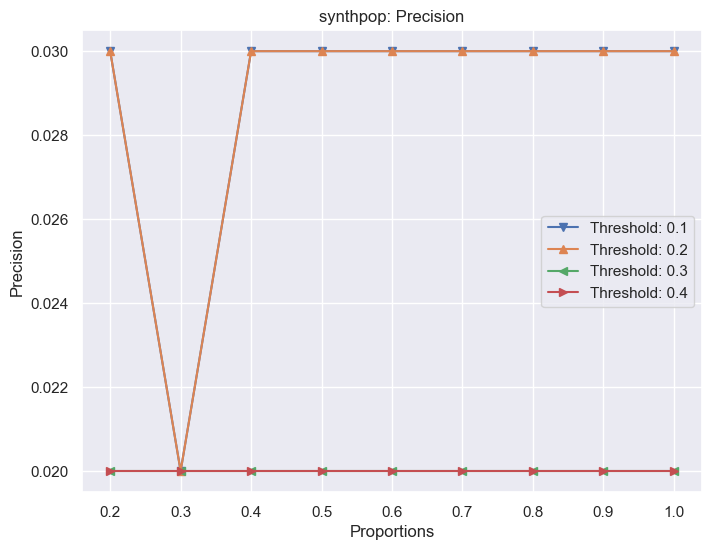

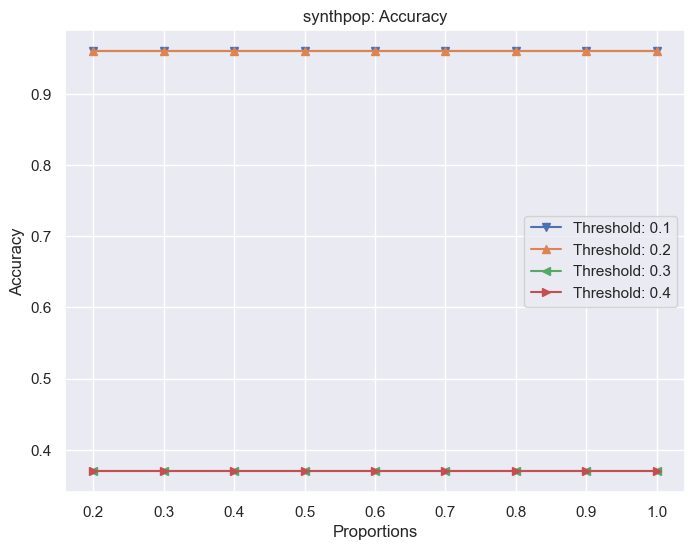

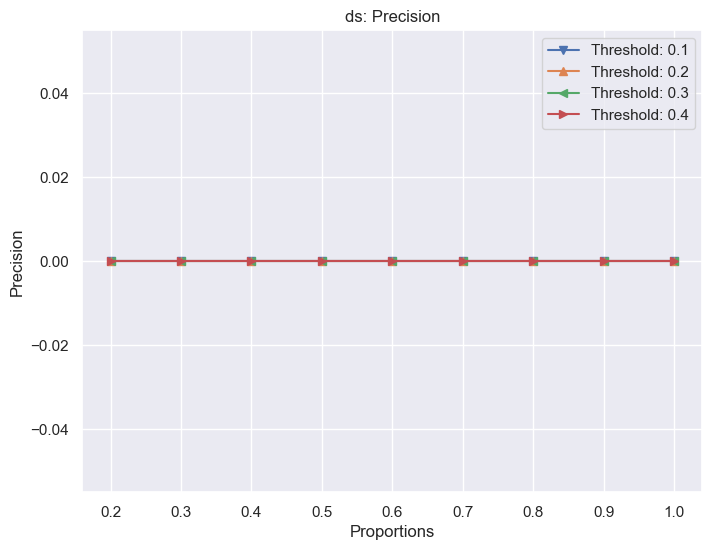

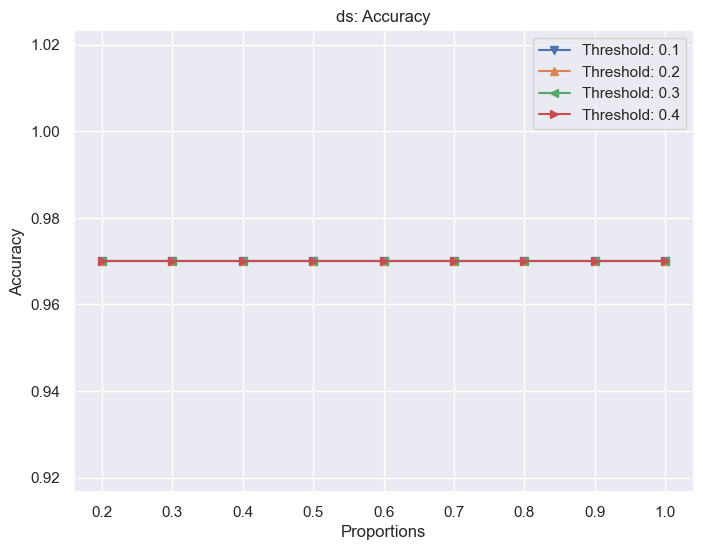

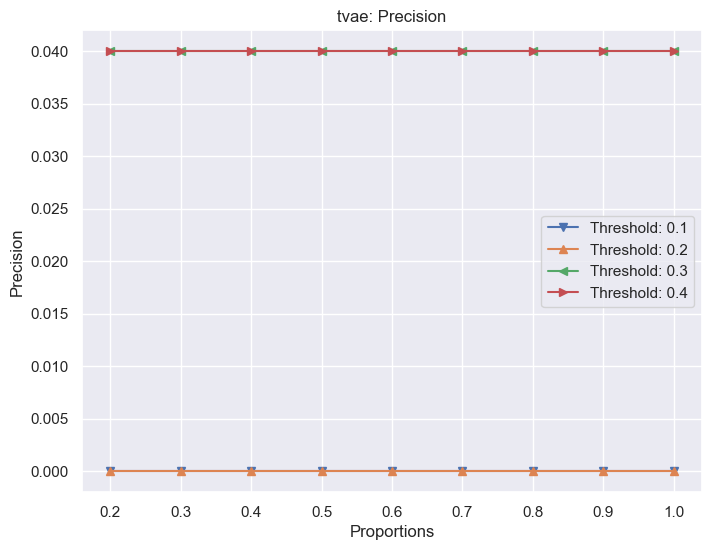

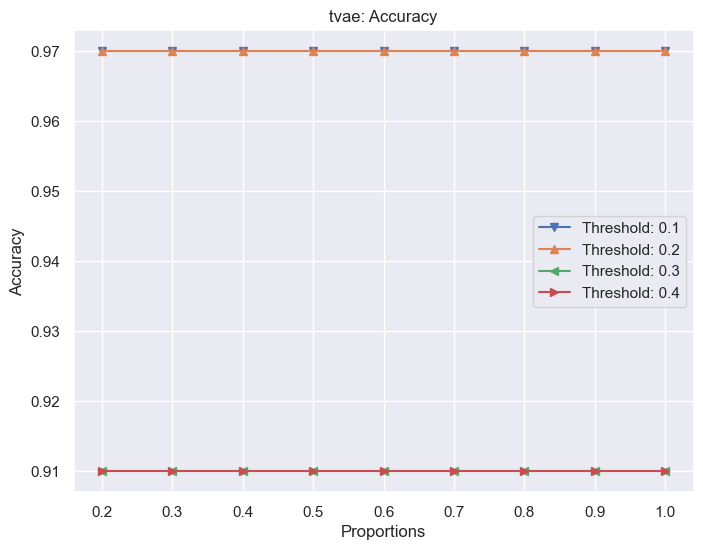

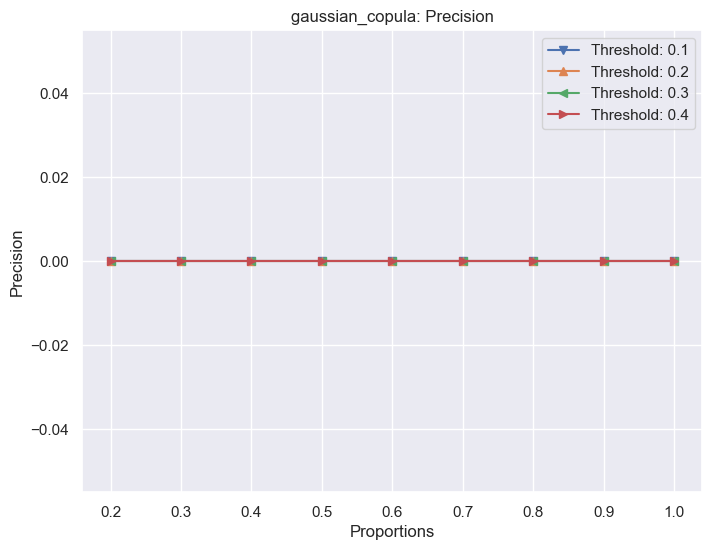

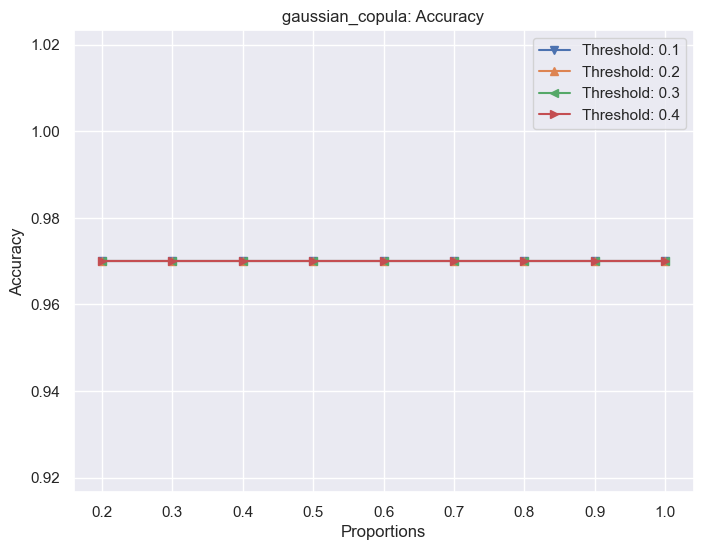

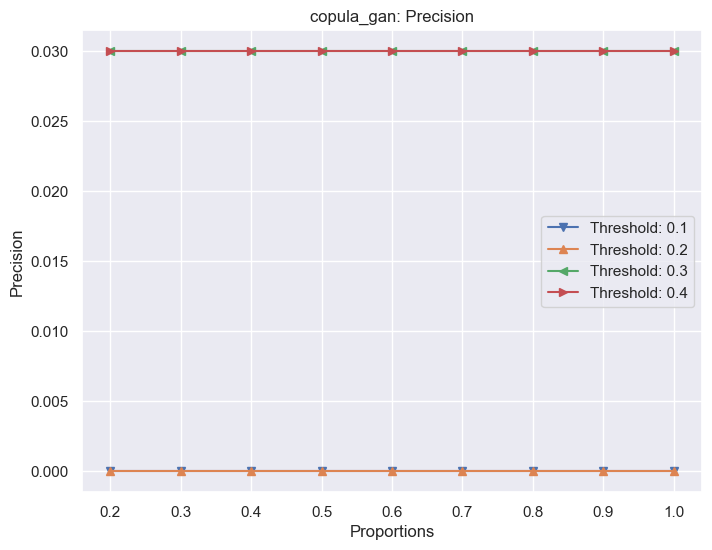

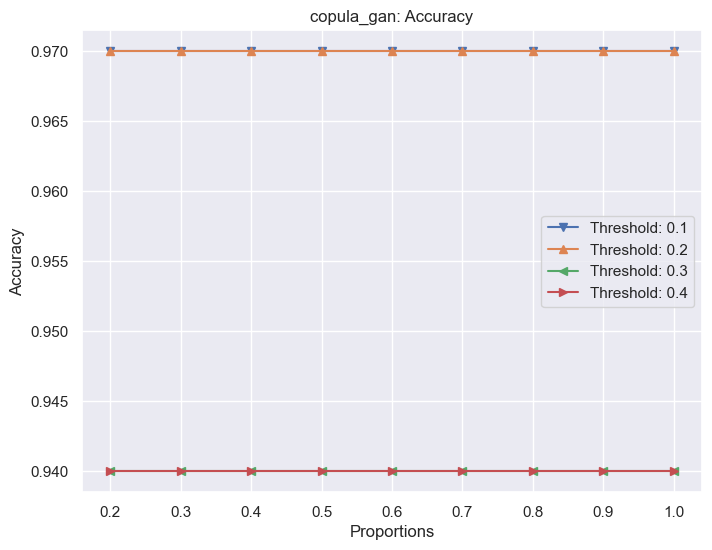

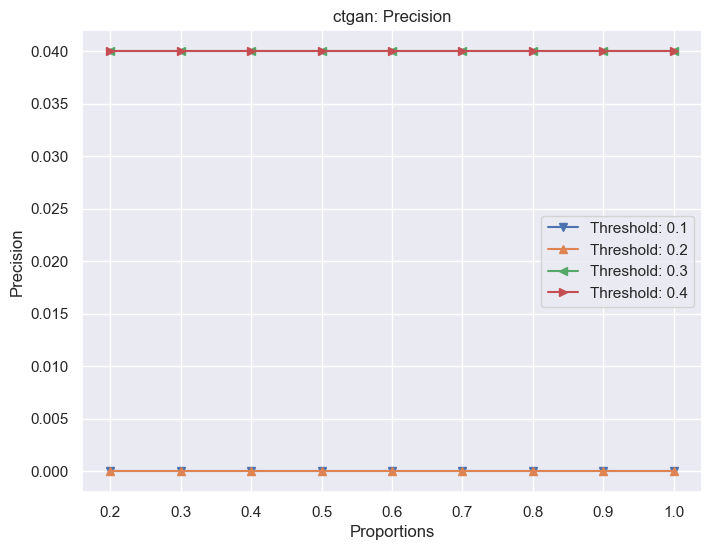

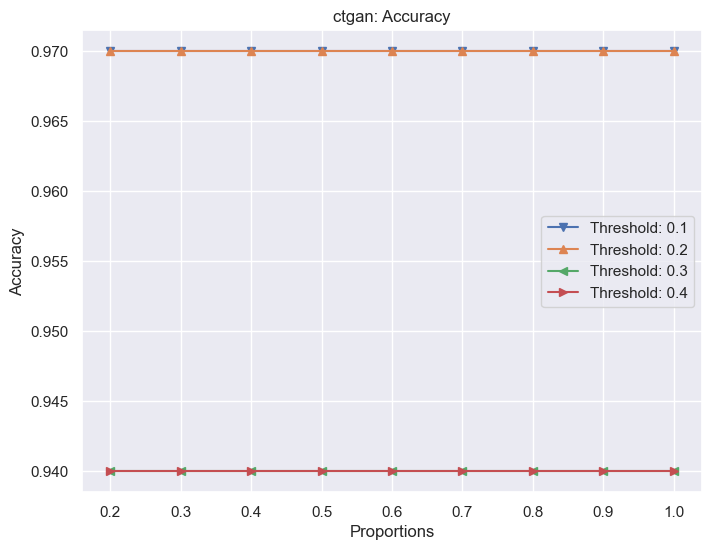

In [21]:
mia_results = {}
for i, model in enumerate(models):
    mia_results[model_names[i]] = mia(train_data, model, model_names[i], dataset_nr=4, save_plts=True)
